## Smoothing

#### https://www.displayr.com/smoothing-time-series-data/

The aim of smoothing is to remove “irregular” noise and cyclical components of the time series. It aims to provide a more accurate prediction of the long term trend. If long term trend is what you want to forecast, then smoothing techniques are generally quite helpful.

Moving average can be used as a data preparation technique to create a smoothed version of the original dataset.

Smoothing is useful as a data preparation technique as it can reduce the random variation in the observations and better expose the structure of the underlying causal processes.

The rolling() function on the Series Pandas object will automatically group observations into a window. You can specify the window size, and by default a trailing window is created. Once the window is created, we can take the mean value, and this is our transformed dataset.


In [20]:
# import statements

import pandas as pd
import numpy as np
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import Series

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, BatchNormalization

from sklearn.model_selection import train_test_split
from random import shuffle

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score, confusion_matrix



In [2]:
# Read the Gear2 data
Gear2Files = ['./Gear2/segment2.csv', './Gear2/segment3.csv','./Gear2/segment4.csv',
              './Gear2/segment5.csv','./Gear2/segment6.csv']

X_Gear2=[0] * len(Gear2Files)
Y_Gear2=[0] * len(Gear2Files)
for index,file in enumerate(Gear2Files):
    X_Gear2[index] = pd.read_csv(file);
    Y_Gear2[index] = pd.DataFrame(data= np.full((X_Gear2[index].shape[0],1), 2));
    X_Gear2[index] = X_Gear2[index].assign(Gear=Y_Gear2[index].values);

# Read the Gear3 data
Gear3Files = ['./Gear3/segment1.csv', './Gear3/segment2.csv','./Gear3/segment3.csv',
              './Gear3/segment4.csv','./Gear3/segment5.csv', './Gear3/segment6.csv']

X_Gear3=[0] * len(Gear3Files)
Y_Gear3=[0] * len(Gear3Files)
for index,file in enumerate(Gear3Files):
    X_Gear3[index] = pd.read_csv(file);
    Y_Gear3[index] = pd.DataFrame(data= np.full((X_Gear3[index].shape[0],1), 3));
    X_Gear3[index] = X_Gear3[index].assign(Gear=Y_Gear3[index].values);

# Read the Gear4 data
Gear4Files = ['./Gear4/segment2.csv','./Gear4/segment3.csv','./Gear4/segment4.csv',
              './Gear4/segment5.csv', './Gear4/segment6a.csv','./Gear4/segment6b.csv']

X_Gear4=[0] * len(Gear4Files)
Y_Gear4=[0] * len(Gear4Files)
for index,file in enumerate(Gear4Files):
    X_Gear4[index] = pd.read_csv(file);
    Y_Gear4[index] = pd.DataFrame(data= np.full((X_Gear4[index].shape[0],1), 4));
    X_Gear4[index] = X_Gear4[index].assign(Gear=Y_Gear4[index].values);

# Read the Gear 5 data
Gear5Files = ['./Double/segment1.csv','./Double/segment2.csv','./Double/segment3.csv',
              './Double/segment4.csv', './Double/segment5.csv','./Double/segment7.csv']

X_Gear5=[0] * len(Gear5Files)
Y_Gear5=[0] * len(Gear5Files)
for index,file in enumerate(Gear5Files):
    X_Gear5[index] = pd.read_csv(file);
    Y_Gear5[index] = pd.DataFrame(data= np.full((X_Gear5[index].shape[0],1), 5));
    X_Gear5[index] = X_Gear5[index].assign(Gear=Y_Gear5[index].values);

In [3]:
# Implement moving average for a window size of 3, and split the segments such that each has 750 time-steps

limit = 750
features = list(X_Gear2[0].columns);
scaledFeatures = [item for item in features if item not in ['t','Gear']]

XGear=[]
for index in range(len(X_Gear2)):
    dataG2 = X_Gear2[index];
    x = dataG2[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear2[index][scaledFeatures] = rolling_mean;
    dataG2 = X_Gear2[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG2)/limit);
    XGear += [dataG2[t*limit:t*limit + limit] for t in range(gearRange)];  
    
for index in range(len(X_Gear3)):
    dataG3 = X_Gear3[index];
    x = dataG3[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear3[index][scaledFeatures] = rolling_mean;
    dataG3 = X_Gear3[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG3)/limit);
    XGear += [dataG3[t*limit:t*limit + limit] for t in range(gearRange)];  
    
for index in range(len(X_Gear4)):
    dataG4 = X_Gear4[index];
    x = dataG4[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear4[index][scaledFeatures] = rolling_mean;
    dataG4 = X_Gear4[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG4)/limit);
    XGear += [dataG4[t*limit:t*limit + limit] for t in range(gearRange)];  
    
    
for index in range(len(X_Gear5)):
    dataG5 = X_Gear5[index];
    x = dataG5[scaledFeatures];
    rolling = x.rolling(window=10);
    rolling_mean = rolling.mean();
    X_Gear5[index][scaledFeatures] = rolling_mean;
    dataG5 = X_Gear5[index].iloc[10:, :];
    gearRange = math.ceil(len(dataG5)/limit);
    XGear += [dataG5[t*limit:t*limit + limit] for t in range(gearRange)];  
    
    

In [4]:
X = XGear[:] # Copy words
shuffle(X) 

In [5]:
X = pd.concat(X);

In [6]:
data = pd.DataFrame(X);

data.reset_index(inplace = True, drop = True)
for i in range(len(data)):
    data.loc[i,'t'] = i*0.02

In [7]:
# Create one-hot Y vectors
features.remove('Gear')
X = data[features]
Y = data['Gear']
# Create one-hot Y vectors
Y_onehot = pd.get_dummies(Y).values;

In [8]:
X = np.array(X)
Y = np.array(Y_onehot)

In [9]:
timesteps = 1
XNew = X.reshape(X.shape[0],timesteps,21)
YNew = Y.reshape(Y.shape[0],timesteps,4)

trainX, testX, trainY, testY = train_test_split(XNew, YNew, test_size=0.2);

trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2);

In [10]:
# design and fit our LSTM network

model = Sequential();
model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, 20)));
model.add(Dense(4, activation = 'softmax'));
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
history = model.fit(trainX[:,:,1:], trainY, epochs=50, batch_size=100, validation_data=(valX[:,:,1:],valY))


Train on 16460 samples, validate on 4116 samples
Epoch 1/50
16460/16460 [==============================] - 6s 374us/step - loss: 0.8026 - categorical_accuracy: 0.6844 - val_loss: 0.5896 - val_categorical_accuracy: 0.7777
Epoch 2/50
16460/16460 [==============================] - 5s 323us/step - loss: 0.4913 - categorical_accuracy: 0.8211 - val_loss: 0.4312 - val_categorical_accuracy: 0.8499
Epoch 3/50
16460/16460 [==============================] - 5s 303us/step - loss: 0.3668 - categorical_accuracy: 0.8750 - val_loss: 0.3368 - val_categorical_accuracy: 0.8790
Epoch 4/50
16460/16460 [==============================] - 5s 285us/step - loss: 0.2954 - categorical_accuracy: 0.8974 - val_loss: 0.2801 - val_categorical_accuracy: 0.9006
Epoch 5/50
16460/16460 [==============================] - 5s 302us/step - loss: 0.2457 - categorical_accuracy: 0.9158 - val_loss: 0.2476 - val_categorical_accuracy: 0.9082
Epoch 6/50
16460/16460 [==============================] - 5s 319us/step - loss: 0.2123 - ca

Epoch 48/50
16460/16460 [==============================] - 5s 278us/step - loss: 0.0277 - categorical_accuracy: 0.9930 - val_loss: 0.0385 - val_categorical_accuracy: 0.9869
Epoch 49/50
16460/16460 [==============================] - 5s 306us/step - loss: 0.0259 - categorical_accuracy: 0.9927 - val_loss: 0.0401 - val_categorical_accuracy: 0.9852
Epoch 50/50
16460/16460 [==============================] - 4s 257us/step - loss: 0.0256 - categorical_accuracy: 0.9934 - val_loss: 0.0330 - val_categorical_accuracy: 0.9896


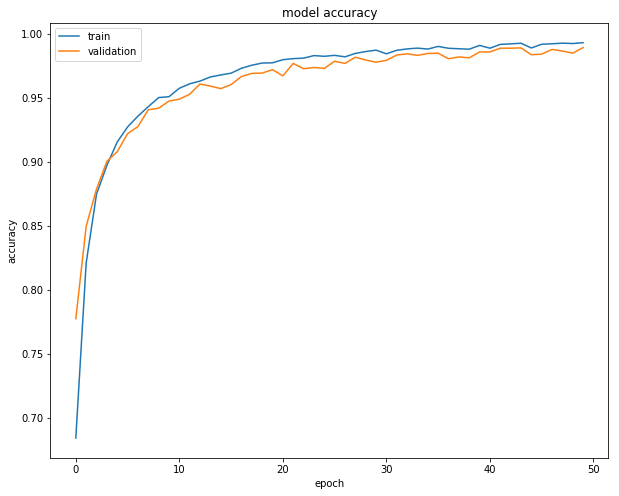

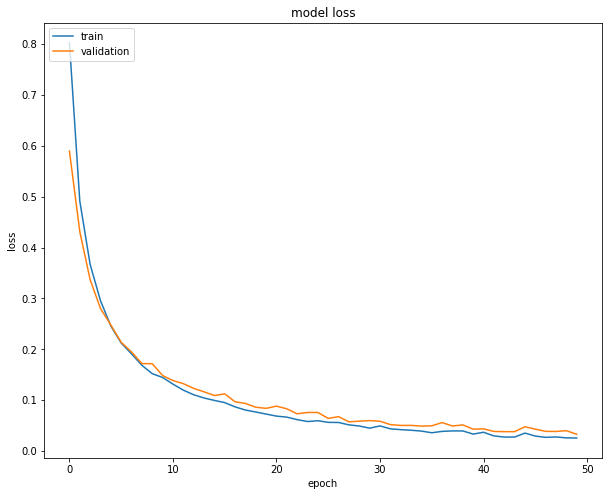

In [11]:
# summarize history for accuracy
plt.figure(0,figsize=(10, 8))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(0,figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
# Evaluate
predictions = model.predict_classes(testX[:,:,1:])

In [13]:
scores = model.evaluate(testX[:,:,1:], testY, verbose=2)
print(scores)

[0.032061372626526495, 0.9906687402799378]


In [14]:
timeTest = np.array(testX[:,:,0])
forceLeftTest = np.array(testX[:,:,1])
forceRightTest = np.array(testX[:,:,9])
predTest = np.array(predictions+2)
realTest = np.array(np.argmax(testY, axis=2)+2)
result = np.concatenate((timeTest,forceLeftTest, forceRightTest, predTest, realTest), axis=1)

In [15]:
ind=np.argsort(result[:,0])
result2 = result[ind]

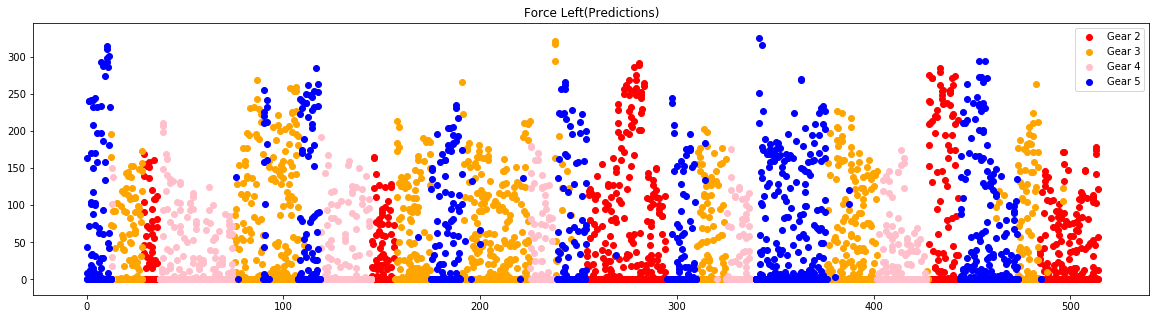

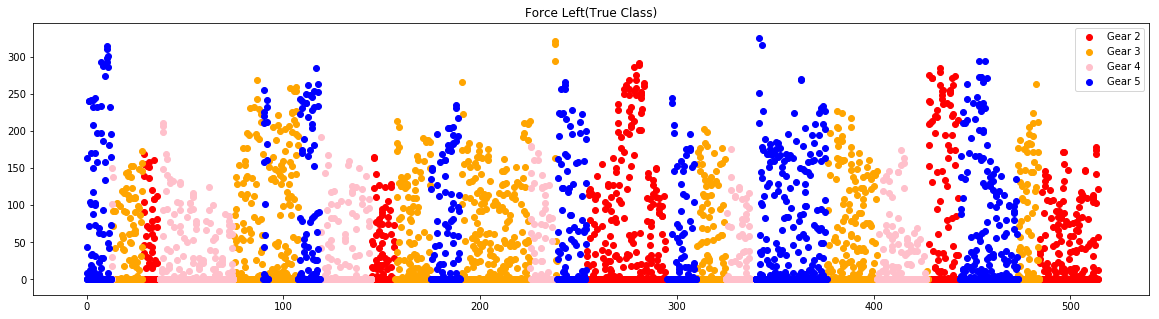

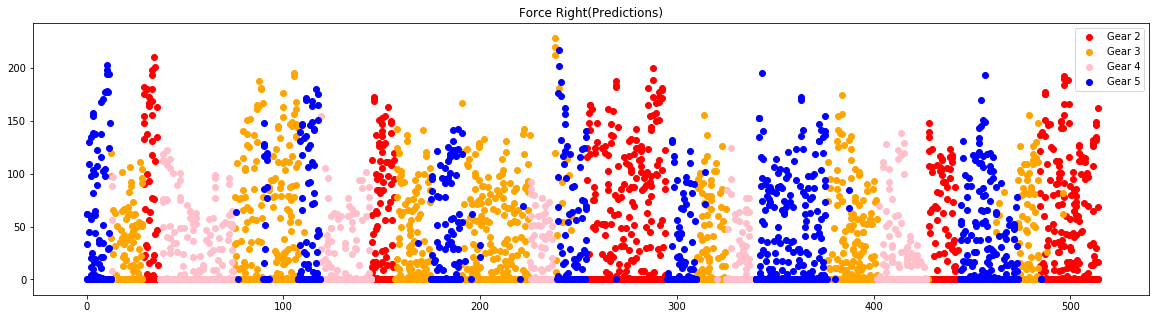

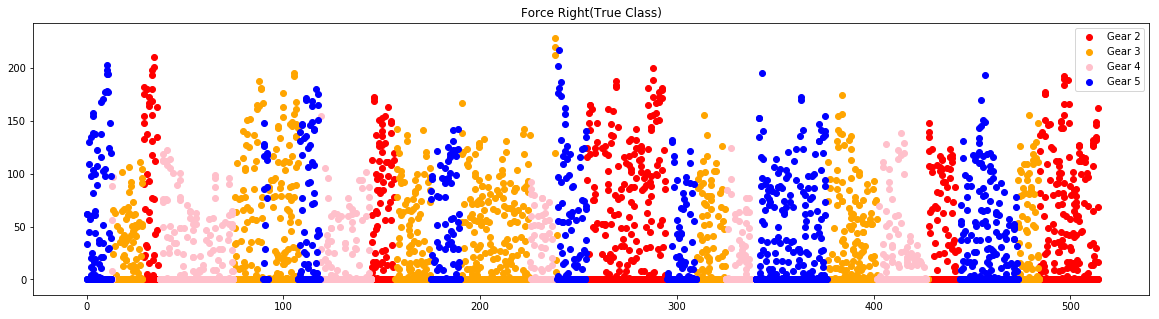

In [16]:
plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Left(Predictions)')
for i in range(2,6):
    classResult = result[result[:,3]==i]
    plt.scatter(classResult[:,0],classResult[:,1],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Left(True Class)')
for i in range(2,6):
    classRealResult = result[result[:,4]==i]
    plt.scatter(classRealResult[:,0],classRealResult[:,1],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
plt.title('Force Right(Predictions)')
for i in range(2,6):
    classResult = result[result[:,3]==i]
    plt.scatter(classResult[:,0],classResult[:,2],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()

plt.figure(0,figsize=(20, 5))
color = {2:'red',3:'orange',4:'pink', 5:'blue'}
plt.title('Force Right(True Class)')
for i in range(2,6):
    classRealResult = result[result[:,4]==i]
    plt.scatter(classRealResult[:,0],classRealResult[:,2],c =color[i],label='Gear ' + str(i))
    plt.legend()
plt.show()


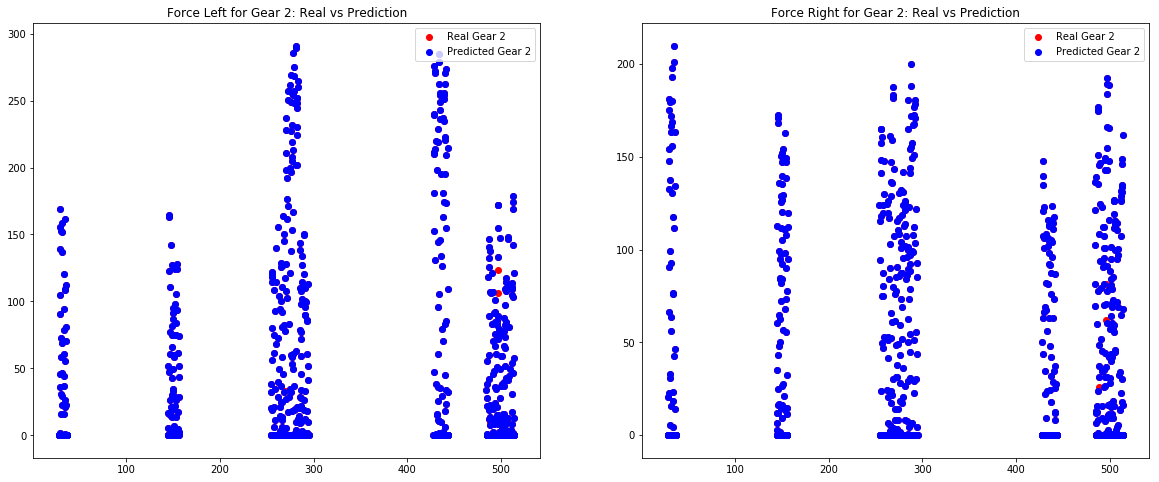

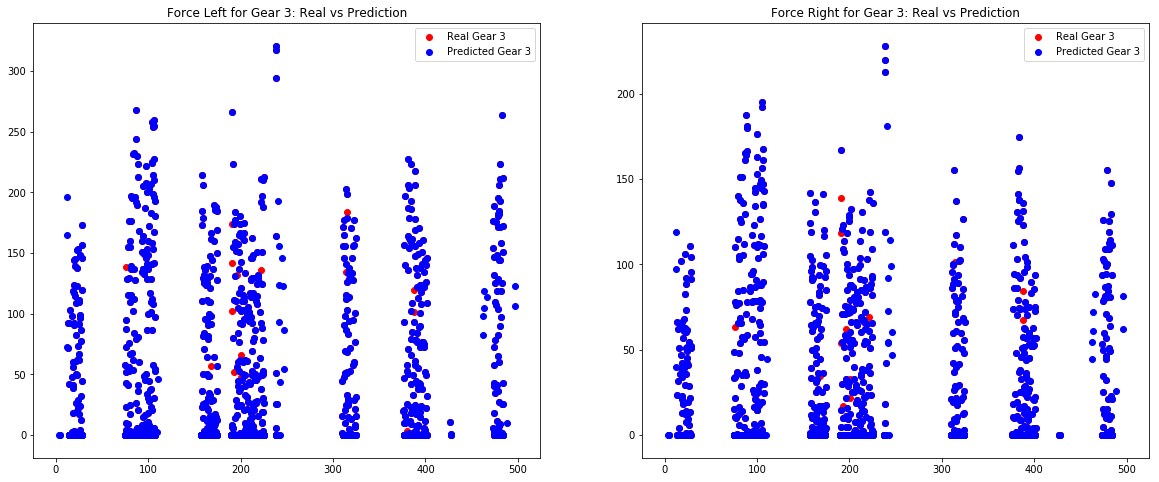

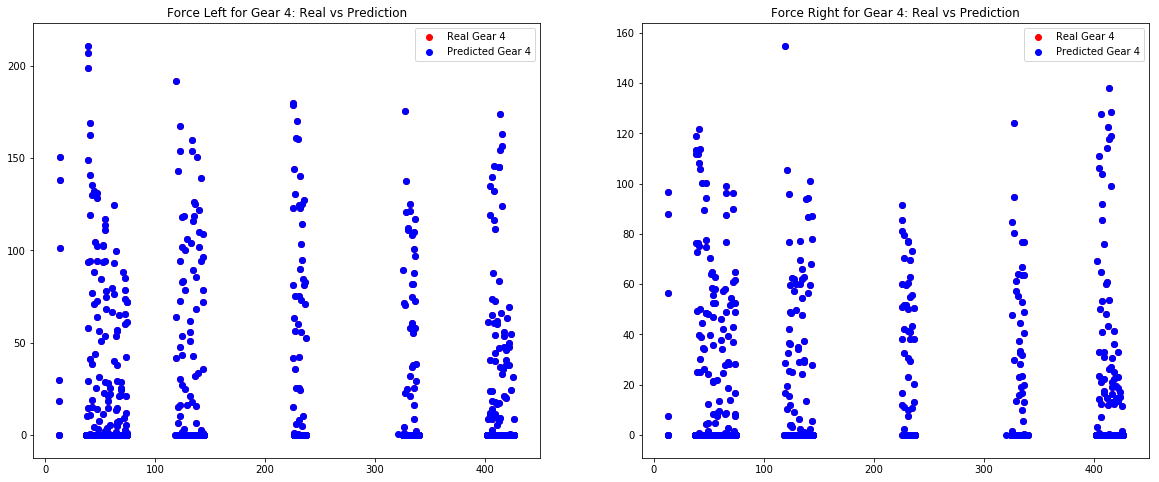

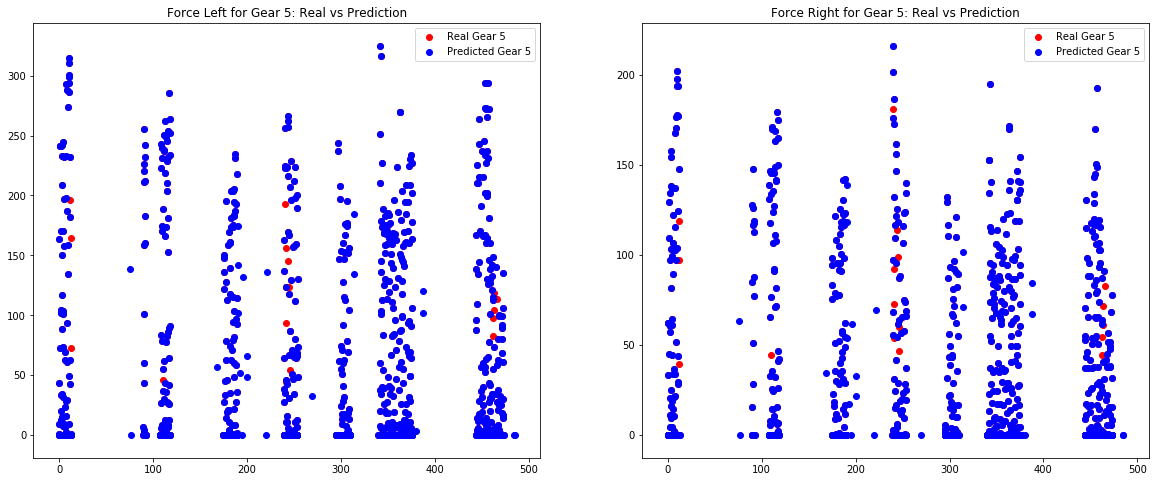

In [17]:
for i in range(2,6):
    classPredResult = result[result[:,3]==i]
    classRealResult = result[result[:,4]==i]
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))
    
    ax1.set_title('Force Left for Gear '+str(i) +': Real vs Prediction') 
    ax1.scatter(classRealResult[:,0],classRealResult[:,1],c ='red',label='Real Gear ' + str(i))
    ax1.scatter(classPredResult[:,0],classPredResult[:,1],c ='blue',label='Predicted Gear ' + str(i))
    ax1.legend(loc="upper right")
    
    ax2.set_title('Force Right for Gear '+str(i) +': Real vs Prediction') 
    ax2.scatter(classRealResult[:,0],classRealResult[:,2],c ='red',label='Real Gear ' + str(i))
    ax2.scatter(classPredResult[:,0],classPredResult[:,2],c ='blue',label='Predicted Gear ' + str(i))
    ax2.legend(loc="upper right")
plt.show()    

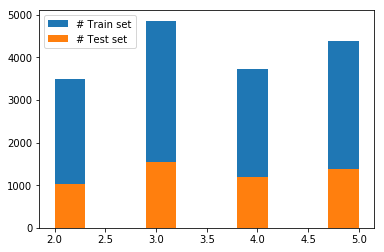

In [18]:
# Count of data for each gear in training set
i = (np.argmax(trainY, axis = 2)) + 2

# Count of data for each gear in test set
j = (np.argmax(testY, axis = 2)) + 2

plt.hist(i, label = '# Train set')
plt.hist(j, label = '# Test set')
plt.legend()
plt.show()